In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit, expit
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [32]:

def rescale_beta(x, lower=-3, upper=3):
    res = (x - lower) / (upper - lower)
    return((res * (len(x) - 1) + .5) / len(x))


def standardize(x):
    return( (x - np.mean(x))/np.std(x) )


def tiers2blacklist(tiers):
    total_nodes = len(tiers)
    adj = np.zeros((total_nodes, total_nodes))
    
    # i,j = 1 if tier i <= tier j
    for i in range(total_nodes):
        t_i = tiers[i]
        for j in range(total_nodes):
            t_j = tiers[j]
            if i != j:
                if t_i < t_j:
                    adj[i,j] = 1

    return(adj.T)

bl = tiers2blacklist([ 1,1,1, 2,2,2,2,2,2,2,2,3, 0, 0])
# bl = pd.read_csv("data/theory-bl.csv")
# node_order = bl.columns.to_list()

node_order = ['medSkept',
 'overpar',
 'parentExpert',
 'diseaseRare',
 'diseaseSevere',
 'vaccEff',
 'vaccTox',
 'vaccStrain',
 'vaccDanger',
 'infantImmLimCap',
 'infantImmWeak',
 'vaccIntent',
 'hb',
 'nat']

df_raw = pd.read_csv("data/s1-data.csv")
df_raw = df_raw[node_order]

df_raw.head()

,medSkept,overpar,parentExpert,diseaseRare,diseaseSevere,vaccEff,vaccTox,vaccStrain,vaccDanger,infantImmLimCap,infantImmWeak,vaccIntent,hb,nat
0,-1.500000,0.0,0.0,0.6,2.2,1.75,-2.75,-1.0,-2.75,0.0,-1.2,2.6,1.50,-0.166667
1,2.166667,1.0,1.2,-3.0,3.0,-1.25,2.75,3.0,1.25,2.6,3.0,-0.4,0.50,1.000000
2,-0.166667,0.4,0.0,-1.2,2.0,1.00,-2.00,-0.8,-1.50,-0.2,0.4,1.6,0.25,-0.666667
3,-0.166667,0.0,-0.4,0.0,0.6,0.00,-0.50,0.0,-0.50,0.4,0.2,0.0,1.00,0.166667
4,0.166667,0.2,-0.2,-0.4,1.6,-0.50,1.25,0.8,0.75,-0.4,0.8,0.0,2.25,0.000000


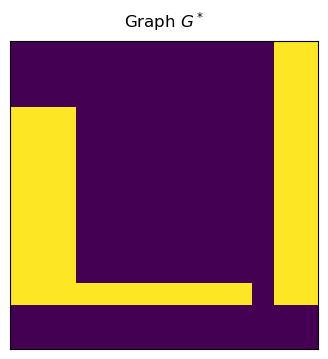

In [33]:
import matplotlib.pyplot as plt

def visualize_adj_matrix(mat, size=4.0):
    """    
    `mat`: (d, d) 
    """
    ## from DIBS library: https://github.com/larslorch/dibs/tree/master
    plt.rcParams['figure.figsize'] = [size, size]
    fig, ax = plt.subplots(1, 1)
    ax.matshow(mat, vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title(r'Graph $G^*$', pad=10)
    plt.show()
    return

visualize_adj_matrix(bl)


In [42]:
import torch
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

class DagmaMLP2(DagmaMLP):

    def __init__(self, blackadj = None, **kwargs): # replace with 
        
        super().__init__(**kwargs)
        if blackadj is None:
            self.blackadj = torch.zeros(self.d, self.d).detach()
        else:
            self.blackadj = blackadj.detach()

    def h_func(self, s: float = 1.0) -> torch.Tensor:
        r"""
        Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG

        Parameters
        ----------
        s : float, optional
            Controls the domain of M-matrices, by default 1.0

        Returns
        -------
        torch.Tensor
            A scalar value of the log-det acyclicity function :math:`h(\Theta)`.
        """
        
        fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(self.d, -1, self.d)
        A = torch.sum(fc1_weight ** 2, dim=1).t()  # [i, j]
        h = -torch.slogdet(s * self.I - A)[1] + self.d * np.log(s) # +inf when not a DAG

        return h + ((A * self.blackadj).sum())*1e16


class DagmaLinear2(DagmaLinear):

    def predict(self, X = None):
        if X is None:
            X = self.X

        return X @ self.W_est


# class DagmaNonlinearBeta(DagmaNonlinear):

#     def log_mse_loss(self, output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
#         r"""
#         Computes the logarithm of the MSE loss:
#             .. math::
#                 \frac{d}{2} \log\left( \frac{1}{n} \sum_{i=1}^n (\mathrm{output}_i - \mathrm{target}_i)^2 \right)
        
#         Parameters
#         ----------
#         output : torch.Tensor
#             :math:`(n,d)` output of the model
#         target : torch.Tensor
#             :math:`(n,d)` input dataset

#         Returns
#         -------
#         torch.Tensor
#             A scalar value of the loss.
#         """
#         logit = torch.sigmoid(output)
#         # l = torch.nn.KLDivLoss()
#         # loss = l(logit, target)

#         loss = torch.sum(Beta2(logit, 10.).log_prob(target))
#         return loss


def adj_to_edge_tuple(x):
    edge_list = np.stack(np.nonzero(x), axis=-1).tolist()
    return(tuple(tuple(sub) for sub in edge_list))


def Beta2(mu, k):
    return(torch.distributions.Beta(mu*k, (1.-mu)*k))

## Linear model

In [35]:
df = df_raw.apply(standardize)
train, test = train_test_split(df.to_numpy(), test_size=0.2, random_state = 123)

df.head()

,medSkept,overpar,parentExpert,diseaseRare,diseaseSevere,vaccEff,vaccTox,vaccStrain,vaccDanger,infantImmLimCap,infantImmWeak,vaccIntent,hb,nat
0,-1.384762,-0.051236,0.383666,1.513743,0.349602,0.363309,-1.271407,-0.404044,-1.237144,-0.370259,-1.343816,0.788035,1.112192,0.115226
1,1.888120,0.861150,1.387124,-1.744974,1.136251,-1.960636,2.428993,2.780358,1.701806,1.867916,2.088321,-1.534514,0.329358,1.164339
2,-0.194623,0.313719,0.383666,-0.115615,0.152940,-0.217677,-0.766807,-0.244824,-0.318723,-0.542426,-0.036335,0.013852,0.133650,-0.334394
3,-0.194623,-0.051236,0.049180,0.970623,-1.223696,-0.992325,0.242393,0.392057,0.416015,-0.025924,-0.199770,-1.224841,0.720775,0.414972
4,0.102912,0.131241,0.216423,0.608544,-0.240384,-1.379650,1.419793,1.028937,1.334437,-0.714593,0.290535,-1.224841,1.699316,0.265099


In [36]:
model = DagmaLinear2(loss_type='l2') # create a linear model with least squares loss
W_est = model.fit(train, lambda1=0.02, w_threshold = .1, exclude_edges = adj_to_edge_tuple(bl)) # fit the model with L1 reg. (coeff. 0.02)


  0%|          | 0/180000.0 [00:00<?, ?it/s]

In [37]:
np.mean((train - model.predict(torch.tensor(train)).detach().numpy())**2), np.mean((test - model.predict(torch.tensor(test)).detach().numpy())**2)

(0.6315990615318832, 0.6326823900022374)

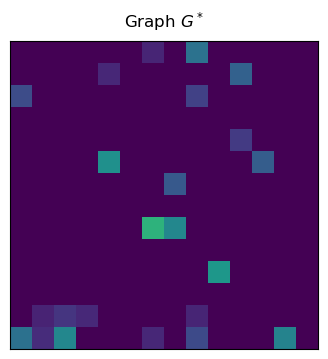

23

In [38]:
visualize_adj_matrix(W_est)
(W_est > 0).sum()

<AxesSubplot:>

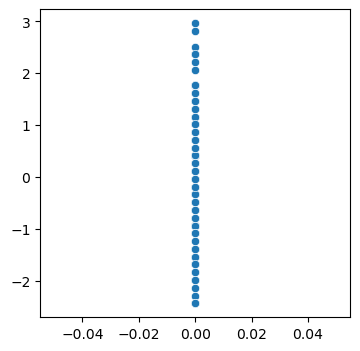

In [40]:
import seaborn as sns
preds = model.predict(test)
sns.scatterplot(x = preds[:,13], y = test[:,13])


## Non-linear model

In [47]:
df = df_raw.apply(rescale_beta)
train, test = train_test_split(df.to_numpy(), test_size=0.2, random_state = 123)
df.head()

,medSkept,overpar,parentExpert,diseaseRare,diseaseSevere,vaccEff,vaccTox,vaccStrain,vaccDanger,infantImmLimCap,infantImmWeak,vaccIntent,hb,nat
0,0.250221,0.500000,0.500000,0.599911,0.866342,0.791408,0.042073,0.333481,0.042073,0.500000,0.300177,0.932950,0.749779,0.472247
1,0.860791,0.666519,0.699823,0.000443,0.999557,0.291851,0.957927,0.999557,0.708149,0.932950,0.999557,0.433392,0.583260,0.666519
2,0.472247,0.566608,0.500000,0.300177,0.833038,0.666519,0.166962,0.366785,0.250221,0.466696,0.566608,0.766430,0.541630,0.388987
3,0.472247,0.500000,0.433392,0.500000,0.599911,0.500000,0.416740,0.500000,0.416740,0.566608,0.533304,0.500000,0.666519,0.527753
4,0.527753,0.533304,0.466696,0.433392,0.766430,0.416740,0.708149,0.633215,0.624889,0.433392,0.633215,0.500000,0.874668,0.500000


In [48]:
eq_model = DagmaMLP2(dims=[14, 10, 1], bias=True, dtype=torch.double, blackadj = torch.tensor(bl)) # create the model for the structural equations, in this case MLPs
model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
W_est = model.fit(torch.tensor(train), lambda1=0.02, lambda2=0.005, w_threshold=.1) # fit the model with L1 reg. (coeff. 0.02) and L2 reg. (coeff. 0.005)

  0%|          | 0/230000.0 [00:00<?, ?it/s]

In [49]:
np.mean((train - model.model(torch.tensor(train)).detach().numpy())**2), np.mean((test - model.model(torch.tensor(test)).detach().numpy())**2)

(0.02396129680535118, 0.02398785150335557)

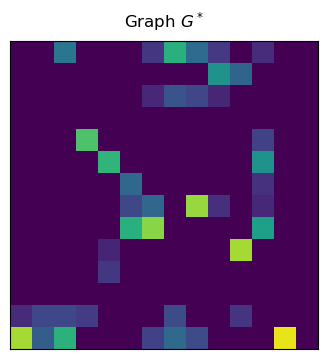

42

In [50]:
visualize_adj_matrix(W_est)
(W_est > 0).sum()

<AxesSubplot:xlabel='None'>

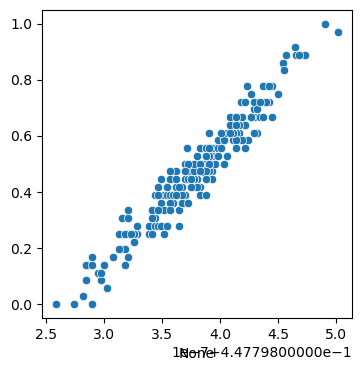

In [51]:
idx = 13
preds = model.model(torch.tensor(test))
sns.scatterplot(x = preds.detach()[:,idx], y = test[:,idx])

## Visualizing results

From the non-linear model.

<Axes:>

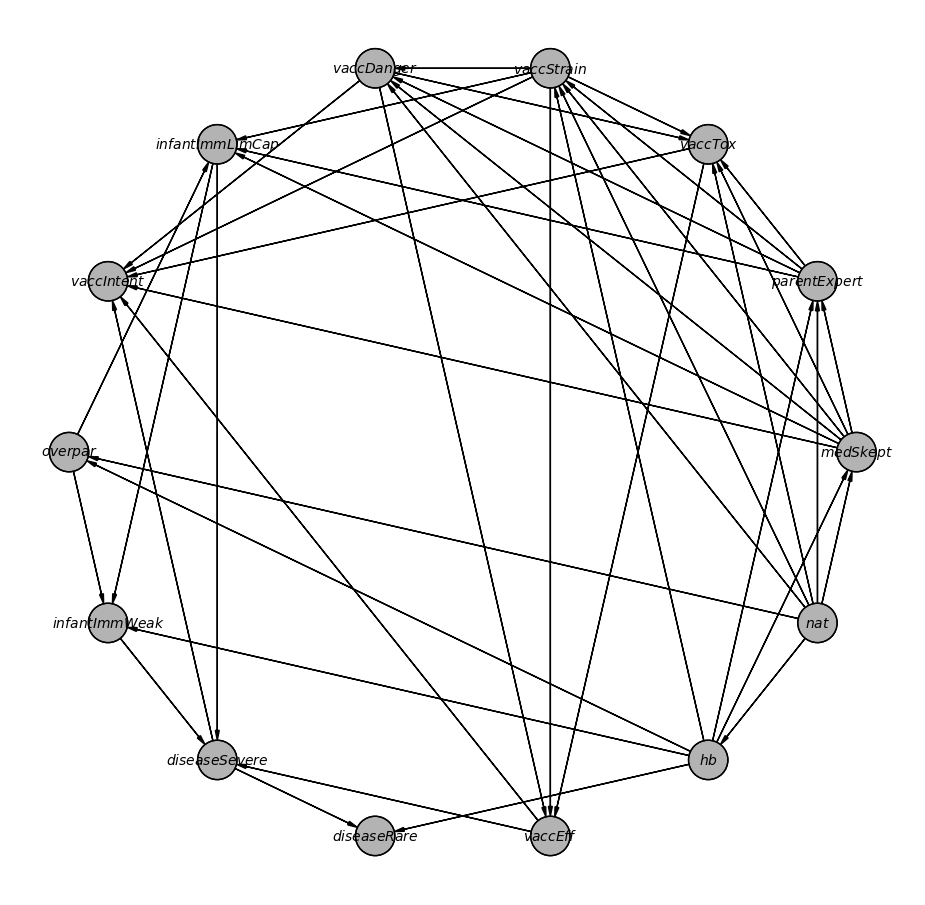

In [52]:
from pgmpy.models import BayesianNetwork

nodes = df.columns.to_list()
model_list = [ (node_order[t[0]], node_order[t[1]]) for t in list(adj_to_edge_tuple(W_est))]

modelx = BayesianNetwork(model_list)
modelx.to_daft('circular', pgm_params={'grid_unit': 10}).render()



Note: code below requires refactoring the data models to output proper probabiltiies or logits

In [53]:
# vaccTox, vaccDanger, vaccStrain, medskept, nat
from pgmpy.factors.discrete.CPD import TabularCPD

def get_cpd_vals(node, parents, fitted_model, orig_data, node_levels = 2):
    # generate values to predict for
    pred_vals = [np.min(df.min()) , np.max(df.max())]
    node_idx = orig_data.columns.get_loc(node)

    if len(parents) > 0:
        d = {p:pred_vals for p in parents}
        data = pd.MultiIndex.from_product(d.values(),names=d.keys()).to_frame().reset_index(drop=True)
    
    
        # plug into skeleton of original dataframe
        dframe = orig_data.head(len(data)).copy()
        
        
        for c in dframe.columns.to_list():
            if c in data.columns.to_list():
                dframe[c] = data[c]
        # do the predictions
        if type(model) == DagmaNonlinear:
            ps = fitted_model.model(torch.tensor(dframe.to_numpy())).detach()
        else:
            ps = fitted_model.predict(dframe.to_numpy())

    else:
        if type(model) == DagmaNonlinear: 
            ps = fitted_model.model(torch.tensor(orig_data.head(1).to_numpy())).detach()
        else:
            ps = fitted_model.predict(orig_data.head(1).to_numpy())
    ps = ps[:, node_idx] # pull out relevant predicted row based on index in original data frame
    ps = expit(ps)

    return(np.stack([ps, 1 - ps]))


def make_cpd(dag, fitted_model, node_name, orig_data, node_levels = 2):
    parents = dag.get_parents(node_name)
    ecard = [node_levels]*len(parents)
    vals = get_cpd_vals(node_name, parents, fitted_model, orig_data, node_levels)
    cpd = TabularCPD(node_name, node_levels, vals, evidence = parents, evidence_card = ecard)
    return(cpd)


def build_bn_cpds(dag, fitted_model, orig_data, node_levels = 2):
    cpdlist = [make_cpd(dag, fitted_model, n, orig_data) for n in dag.nodes()]
    return(cpdlist)
        
    
modelx.add_cpds(*build_bn_cpds(modelx, model, df))

## Inference

In [54]:
from pgmpy.inference import BeliefPropagation, VariableElimination
belief_propagation = BeliefPropagation(modelx)
q = belief_propagation.query(variables=['vaccIntent', 'vaccEff'], evidence={'vaccTox': 0}, joint=True)
print(q)

+---------------+------------+---------------------------+
| vaccIntent    | vaccEff    |   phi(vaccIntent,vaccEff) |
+===============+============+===========================+
| vaccIntent(0) | vaccEff(0) |                    0.4157 |
+---------------+------------+---------------------------+
| vaccIntent(0) | vaccEff(1) |                    0.2254 |
+---------------+------------+---------------------------+
| vaccIntent(1) | vaccEff(0) |                    0.2525 |
+---------------+------------+---------------------------+
| vaccIntent(1) | vaccEff(1) |                    0.1065 |
+---------------+------------+---------------------------+


In [55]:
def make_ER_probs(x):
    vec = np.array([.5*x, .5])
    vec = vec/vec.sum()
    return([[v] for v in vec])


def make_logER_probs(x):
    return(make_ER_probs(np.exp(x)))


virt = TabularCPD("nat", variable_card = 2, values = make_ER_probs(np.exp(-.69)))
q = belief_propagation.query(variables=['nat'], virtual_evidence=[virt], joint=True)
print(q)

+--------+------------+
| nat    |   phi(nat) |
+========+============+
| nat(0) |     0.4397 |
+--------+------------+
| nat(1) |     0.5603 |
+--------+------------+
